## Analysis for paper writing
Author: Sahar H. El Abbadi
Date: 2023-04-12


## Summarize distribution of overpasses

Total number of overpasses, missing data, max and min given to each team, number that passed Stanford QC

Missing overpasses: documented as an overpass by Stanford, but not included in Operator Report file

In [1]:
# All releases conducted
from methods_source import load_overpass_summary, find_missing_data, abbreviate_op_name
import pandas as pd

def summarize_releases(operator, strict_discard=False):
    op_summary = load_overpass_summary(operator, stage=1, strict_discard=strict_discard)
    operator_missing = len(find_missing_data(operator))
    operator_releases = len(op_summary) + operator_missing
    operator_pass_su = len(op_summary.loc[op_summary.stanford_kept == True])
    operator_fail_su = len(op_summary.loc[op_summary.stanford_kept == False])
    op_ab = abbreviate_op_name(operator)
    summary = {
        f'operator': op_ab,
        f'releases': operator_releases,
        f'pass_su': operator_pass_su,
        f'fail_su': operator_fail_su,
        f'missing': operator_missing,
    }
    return summary


cm = summarize_releases('Carbon Mapper')
ghg = summarize_releases('GHGSat')
kairos = summarize_releases('Kairos')
mair = summarize_releases('MethaneAIR')
sciav = summarize_releases('Scientific Aviation', True)
dicts = [cm, ghg, kairos, mair, sciav]

# Combine all dictionaries into one
summary = {key: [d[key] for d in dicts] for key in dicts[0]}

# Convert to DataFrame:
summary = pd.DataFrame.from_records(summary)
print(summary.sum(axis=0))

fail_su                      189
missing                        7
operator    cmghgkairosmairsciav
pass_su                      515
releases                     711
dtype: object


## Determine overpass time

Determine average time for each overpass

In [32]:
from methods_source import load_operator_flight_days

def calc_average_overpass_time(operator):
    op_overpasses = load_overpass_summary(operator, 1)
    op_days = load_operator_flight_days(operator)

    # Set overpass_datetime to index for easier filtering. First save a copy of datetime so I have a column that is not an index
    op_overpasses['datetime_copy'] = op_overpasses['overpass_datetime']
    op_datetime_index = op_overpasses.set_index('overpass_datetime')

    # Set up dictionary for storing data
    timestamps = pd.Series(dtype='float64')

    for i in range(len(op_days)):
        flight_day = op_days.iloc[i].start_time.strftime('%Y-%m-%d')
        daily_overpasses = op_datetime_index.loc[flight_day]
        delta_t = daily_overpasses['datetime_copy'].diff()
        timestamps = pd.concat([timestamps, delta_t])

    average_overpass_time = timestamps.mean()
    overpass_minutes = str(average_overpass_time)[10:15]
    print(f'{operator} average overpass time is {overpass_minutes} minutes')
    return

calc_average_overpass_time('Carbon Mapper')
calc_average_overpass_time('GHGSat')
calc_average_overpass_time('Kairos')
calc_average_overpass_time('MethaneAIR')
calc_average_overpass_time('Scientific Aviation')


Carbon Mapper average overpass time is 12:21 minutes
GHGSat average overpass time is 03:48 minutes
Kairos average overpass time is 03:14 minutes
MethaneAIR average overpass time is 22:13 minutes
Scientific Aviation average overpass time is 40:05 minutes


#### Carbon Mapper overpass summary for results

In [7]:
from writing_analysis import operator_releases_summary_stats
# Carbon Mapper
operator = 'Carbon Mapper'
operator_releases_summary_stats(operator)

Carbon Mapper: 121 flightlines reported to SU
8 overpasses that fail SU QC
113 overpasses that pass SU QC
82 overpasses quantified by Carbon Mapper
31 overpasses removed by Carbon Mapper

3 overpasses documented by Stanford but not reported by Carbon Mapper

Total releases conducted by Stanford (including missing overpasses not reported by Carbon Mapper: 124

Smallest non-zero volume overpass for Carbon Mapper that passes SU qc:
Release Rate: 4.4451804176775 kg CH4 / hr
[4.301638947741193, 4.588721887613808, 95% CI]
(sigma from gas flow: 0.067039)
(sigma from meter: 0.039443)
(sigma from gas composition: 0.001617)
(combined total sigma: 0.073235)

Smallest non-zero volume overpass for Carbon Mapper that passes operator and SU qc:
Release Rate: 4.4451804176775 kg CH4 / hr
[4.301638947741193, 4.588721887613808, 95% CI]
(sigma from gas flow: 0.067039)
(sigma from meter: 0.039443)
(sigma from gas composition: 0.001617)
(combined total sigma: 0.073235)

Largest volume overpass for Carbon Ma

### GHGSat summary for results

In [ ]:
from writing_analysis import operator_releases_summary_stats
# GHGSat
operator = 'GHGSat'
operator_releases_summary_stats(operator)

In [ ]:
# Check GHGSat's internal QC for points they quantified but flagged as sub-optimal

from methods_source import load_operator_report_dictionary, load_overpass_summary
operator = 'GHGSat'
ghg_report = load_operator_report_dictionary()['ghg_1']

# QC flag of GH-2 means that emissions were quantified despite sub-optimal conditions.
# QC flag of GH-4 means diffuse emissions visible over site

ghg_report_quantified = ghg_report.loc[ghg_report.QuantifiedPlume == True]
qc_mask = (ghg_report_quantified['QCFlag'] == 'GH-2') | (ghg_report_quantified['QCFlag'] == 'GH-4')
ghg_report_poor_conditions = ghg_report_quantified.loc[qc_mask]
# list of overpass ID's with poor conditions but quantified
poor_condition_overpasses = ghg_report_poor_conditions['overpass_id']
overpasses = load_overpass_summary(operator, stage=1)

# Find the overpasses in the overpass summary, to see which ones of them pass Stanford QC
poor_condition_overpass_summary = overpasses[overpasses['overpass_id'].isin(poor_condition_overpasses)]

# Select overpasses that pass Stanford QC
poor_condition_overpasses_pass_SU = poor_condition_overpass_summary.loc[poor_condition_overpass_summary.stanford_kept == True]

print(f'Number of overpasses that pass SU quality control but are flagged by GHGSat as sub-optimal conditions for quantification: {len(poor_condition_overpasses_pass_SU)}')

In [ ]:
# Further investigate GHGSat false negatives, as they detect small releases but also had some higher false negatives
from methods_source import load_overpass_summary, classify_confusion_categories

from writing_analysis import print_overpass_info

operator = 'GHGSat'
overpasses = load_overpass_summary(operator, stage=1)
pass_su_qc = overpasses.loc[overpasses.qc_summary == 'pass_all']
true_positives, false_positives, true_negatives, false_negatives = classify_confusion_categories(pass_su_qc)

# How many of these releases were less than 5 kgh?
small_false_negatives = false_negatives.loc[false_negatives['release_rate_kgh'] < 5]
print(f'Number of false negatives that were less than 5 kgh: {len(small_false_negatives)}\n')

# How many of these releases were less than 5 kgh?
large_false_negatives = false_negatives.loc[false_negatives['release_rate_kgh'] > 5]
print(f'False negatives that were above 5 kgh:\n')
print(large_false_negatives['release_rate_kgh'])
print(f'\n')

# print details of each of hte false negatives that is over 5 kgh
for index, row in large_false_negatives.iterrows():
    print_overpass_info(row)

### Kairos summary for results

In [ ]:
from writing_analysis import operator_releases_summary_stats
# GHGSat
operator = 'Kairos'
operator_releases_summary_stats(operator)

In [ ]:
# Additional Kairos analysis
from methods_source import load_overpass_summary
# How many overpasses were at or below 10 kg/hr
operator = 'Kairos'
overpasses = load_overpass_summary(operator, stage=1)
pass_all_qc = overpasses.loc[overpasses.pass_all_qc == True]

lower_end = pass_all_qc.loc[pass_all_qc.release_rate_kgh < 15]
print(f'Total number of releases for {operator} less than 15 kgh: {len(lower_end)} ')

### MethaneAIR summary for results


In [33]:
### MethaneAIR
from writing_analysis import operator_releases_summary_stats
operator = 'MethaneAIR'
operator_releases_summary_stats(operator)

MethaneAIR: 24 flightlines reported to SU
4 overpasses that fail SU QC
20 overpasses that pass SU QC
20 overpasses quantified by MethaneAIR
0 overpasses removed by MethaneAIR

2 overpasses documented by Stanford but not reported by MethaneAIR

Total releases conducted by Stanford (including missing overpasses not reported by MethaneAIR: 26

Smallest non-zero volume overpass for MethaneAIR that passes SU qc:
Release Rate: 24.420141170712 kg CH4 / hr
[24.30721630677572, 24.53306603464828, 95% CI]
(sigma from gas flow: 0.035178)
(sigma from meter: 0.032765)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.057615)

Smallest non-zero volume overpass for MethaneAIR that passes operator and SU qc:
Release Rate: 24.420141170712 kg CH4 / hr
[24.30721630677572, 24.53306603464828, 95% CI]
(sigma from gas flow: 0.035178)
(sigma from meter: 0.032765)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.057615)

Largest volume overpass for MethaneAIR that passes SU qc:
Rele

### Scientific Aviation summary for results


In [8]:
### SciAV
from writing_analysis import operator_releases_summary_stats
operator = 'Scientific Aviation'
operator_releases_summary_stats(operator, strict_discard=True)

Scientific Aviation: 18 flightlines reported to SU
1 overpasses that fail SU QC
17 overpasses that pass SU QC
10 overpasses quantified by Scientific Aviation
7 overpasses removed by Scientific Aviation

0 overpasses documented by Stanford but not reported by Scientific Aviation

Total releases conducted by Stanford (including missing overpasses not reported by Scientific Aviation: 18

Smallest non-zero volume overpass for Scientific Aviation that passes SU qc:
Release Rate: 3.773421855090184 kg CH4 / hr
[3.7167966366816088, 3.830047073498759, 95% CI]
(sigma from gas flow: 0.028501)
(sigma from meter: 0.005828)
(sigma from gas composition: 0.002032)
(combined total sigma: 0.028890)

Smallest non-zero volume overpass for Scientific Aviation that passes operator and SU qc:
Release Rate: 3.773421855090184 kg CH4 / hr
[3.7167966366816088, 3.830047073498759, 95% CI]
(sigma from gas flow: 0.028501)
(sigma from meter: 0.005828)
(sigma from gas composition: 0.002032)
(combined total sigma: 0.02

In [ ]:
# Additional Scientific Aviation analysis
from methods_source import load_overpass_summary
# Which dates contained SCIAV qc'ed points
operator = 'Scientific Aviation'
overpasses = load_overpass_summary(operator, strict_discard=True, stage=1)

relevant_col = 'overpass_datetime'
fail_sciav_qc_dates = overpasses.loc[overpasses.operator_kept == False][relevant_col]
print(fail_sciav_qc_dates)

## Analyze Error Bar Profile

What fraction of quantification estimates have upper or lower bounds that cross the parity line? Functions for testing parity apply the following filters to the operator overpasses:
  - Must pass all QC
  - Operator quantification is not null to not include NAN values as False (for not crossing parity line)

In [2]:
from writing_analysis import test_parity_all_stages

# Carbon Mapper
operator = 'Carbon Mapper'
strict_discard = False
test_parity_all_stages(operator)

# GHGSat
operator = 'GHGSat'
strict_discard = False
test_parity_all_stages(operator)

# MethaneAIR
operator = 'MethaneAIR'
strict_discard = False
test_parity_all_stages(operator)

# Scientific Aviation
operator = 'Scientific Aviation'
strict_discard = True
test_parity_all_stages(operator)

Fraction of Carbon Mapper Stage 1 overpasses with 95% CI that encompasses parity line: 89%
Fraction of Carbon Mapper Stage 2 overpasses with 95% CI that encompasses parity line: 76%
Fraction of Carbon Mapper Stage 3 overpasses with 95% CI that encompasses parity line: 80%


Fraction of GHGSat Stage 1 overpasses with 95% CI that encompasses parity line: 93%
Fraction of GHGSat Stage 2 overpasses with 95% CI that encompasses parity line: 84%
Fraction of GHGSat Stage 3 overpasses with 95% CI that encompasses parity line: 84%


Fraction of MethaneAIR Stage 1 overpasses with 95% CI that encompasses parity line: 83%


Fraction of Scientific Aviation Stage 1 overpasses with 95% CI that encompasses parity line: 67%




In [3]:
# Closer look at GHGSat parity plot points and how many cross the parity line

from writing_analysis import calc_parity_intersection
import pathlib
import pandas as pd
operator = 'GHGSat'

ghg_1_df = calc_parity_intersection(operator, 1, strict_discard=False)
ghg_1_df.to_csv(pathlib.PurePath('03_results', 'paper_analysis', 'ghg_1_df_parity_compare.csv'))

ghg_2_df = calc_parity_intersection(operator, 2, strict_discard=False)
ghg_2_df.to_csv(pathlib.PurePath('03_results', 'paper_analysis', 'ghg_2_df_parity_compare.csv'))

compare_ghg = pd.DataFrame()
compare_ghg['stage1_95CI'] = ghg_1_df['operator_95CI_bounds'] # how big are stage 1 error bars?
compare_ghg['stage2_95CI'] = ghg_2_df['operator_95CI_bounds'] # how big are stage 2 error bars?

compare_ghg['CI_ratio'] = compare_ghg['stage2_95CI'] / compare_ghg['stage1_95CI']
compare_ghg['stage1_cross_parity'] = ghg_1_df['intersect_parity_line'] # cross parity in stage 1?
compare_ghg['stage2_cross_parity'] = ghg_2_df['intersect_parity_line'] # cross parity in stage 2?

stage1_95CI_mean = compare_ghg.stage1_95CI.mean()
stage2_95CI_mean = compare_ghg.stage2_95CI.mean()
mean_ratio = compare_ghg.CI_ratio.mean()
stage1_cross_parity = len(compare_ghg.loc[compare_ghg.stage1_cross_parity == True])
stage2_cross_parity = len(compare_ghg.loc[compare_ghg.stage2_cross_parity == True])
print(f'Mean 95% CI error bar length for Stage 1: {stage1_95CI_mean:0.2f}')
print(f'Mean 95% CI error bar length for Stage 2: {stage2_95CI_mean:0.2f}')
print(f'Average ratio between Stage 2 and Stage 1: {mean_ratio:0.4f}')
print(f'Minimum CI ratio: {compare_ghg.CI_ratio.min():0.2f}')
print(f'Minimum CI ratio: {compare_ghg.CI_ratio.max():0.2f}\n')


# flip from cross parity to not cross parity
mask_true_to_false = (compare_ghg.stage1_cross_parity == True) & (compare_ghg.stage2_cross_parity == False)
flip_T_to_F = compare_ghg.loc[mask_true_to_false]

print(f'Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: {len(flip_T_to_F)}\n')

# flip from cross parity to not cross parity
mask_false_to_true = (compare_ghg.stage1_cross_parity == False) & (compare_ghg.stage2_cross_parity == True)
flip_F_to_T = compare_ghg.loc[mask_false_to_true]

print(f'Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: {len(flip_F_to_T)}\n')


Fraction of GHGSat Stage 1 overpasses with 95% CI that encompasses parity line: 93%
Fraction of GHGSat Stage 2 overpasses with 95% CI that encompasses parity line: 84%
Mean 95% CI error bar length for Stage 1: 113.16
Mean 95% CI error bar length for Stage 2: 71.71
Average ratio between Stage 2 and Stage 1: 0.6118
Minimum CI ratio: 0.10
Minimum CI ratio: 1.08

Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: 16

Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: 5



In [5]:
# Scientific Aviation
operator = 'Scientific Aviation'
strict_discard = True
data = calc_parity_intersection(operator, stage=1, strict_discard=True)
cross_parity = data.loc[data['intersect_parity_line'] == True]
print(f'Number of points that cross parity line: {len(cross_parity)}')

Fraction of Scientific Aviation Stage 1 overpasses with 95% CI that encompasses parity line: 62%
Number of points that cross parity line: 5


### Kairos distance from parity line

Kairos does not report uncertainty for their quantification estimates. Thus, we cannot look at how many of the points have error bars that cross the parity line.

Instead, we look at how many are within 25% and 50% of the true value.

In [17]:
from methods_source import load_overpass_summary
import pandas as pd

kairos_1 = load_overpass_summary('Kairos', 1, strict_discard=False)

# Filter for pass all QC
kairos_1 = kairos_1.loc[kairos_1['qc_summary']=='pass_all']

# Remove zero releases:
kairos_1 = kairos_1.loc[kairos_1['non_zero_release'] == True]

# Remove non-detected releases (operator quantification > 0)
kairos_1 = kairos_1.loc[kairos_1['operator_quantification'] > 0]

# Evan in Sherwin et al 2023 says 86% of Kairos quantification estimates fall within +/- 50% of the metered value

kairos_accuracy = pd.DataFrame()
kairos_accuracy['release_rate_kgh'] = kairos_1['release_rate_kgh']
kairos_accuracy['operator_quantification'] = kairos_1['operator_quantification']
kairos_accuracy['release_rate_0.50x'] = kairos_accuracy['release_rate_kgh'] * 0.5
kairos_accuracy['release_rate_1.50x'] = kairos_accuracy['release_rate_kgh'] * 1.5
kairos_accuracy['release_rate_0.25x'] = kairos_accuracy['release_rate_kgh'] * 0.75
kairos_accuracy['release_rate_1.25x'] = kairos_accuracy['release_rate_kgh'] * 1.25

multipliers = ['.25', '.50']
accuracy_record = []
for index, row in kairos_accuracy.iterrows():
    new_row = {}
    for multipler in multipliers:

        upper_col = f'release_rate_1{multipler}x'
        lower_col = f'release_rate_0{multipler}x'
        upper_bound = row[upper_col]
        lower_bound = row[lower_col]
        estimate = row['operator_quantification']
        # print(f'estimate: {estimate}')
        # print(f'upper_bound: {upper_bound}')
        # print(f'low_bound: {lower_bound}')
        if (estimate <= upper_bound) and (estimate >= lower_bound):
            record = True
        else:
            record = False
        new_row['index'] = index
        new_row[f'within_{multipler[1:3]}%'] = record
    accuracy_record.append(new_row)

test_accuracy = pd.DataFrame.from_records(accuracy_record, index='index')
# add_cols=add_cols.astype({"within_25%":bool,"within_50%":bool})

print(f'Sanity check:')
test_mask = (test_accuracy['within_25%'] == True) & (test_accuracy['within_50%'] == False)
print(f'Number of points within 50% accuracy but not within 25% accuracy: {len(test_accuracy.loc[test_mask])}\n')

total_points = len(test_accuracy)
test_25_percent = len(test_accuracy[test_accuracy['within_25%'] == True])
print(f'Number of points within 25% of metered release rate: {test_25_percent}')
percent_within_25_percent = test_25_percent / total_points * 100
print(f'Percentage of measurements within 25% of metered rate: {percent_within_25_percent:.1f}%')

test_50_percent = len(test_accuracy[test_accuracy['within_50%'] == True])
print(f'Number of points within 25% of metered release rate: {test_50_percent}')
percent_within_50_percent = test_50_percent / total_points * 100
print(f'Percentage of measurements within 25% of metered rate: {percent_within_50_percent:.1f}%')

Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 47
Percentage of measurements within 25% of metered rate: 37.9%
Number of points within 25% of metered release rate: 91
Percentage of measurements within 25% of metered rate: 73.4%


## Analyze Error Profile - Absolute, Percent Error

- Examine percent and absolute error profile in quantification estimates
- Only include points that pass all QC
- Residuals compare the quantification estimate to the OLS best fit


First, determine the ranges for residuals, absolute error, and percent error. These are used in making the figures in 11_paper_figures

In [ ]:
from writing_analysis import determine_relevant_error_ranges
# Determine what to use for axis across all plots
# First find min and max for residuals
from methods_source import abbreviate_op_name
import pandas as pd
from writing_analysis import summarize_operator_stages_defaults


operator_stages = summarize_operator_stages_defaults()

summary = []
for index, test in operator_stages.iterrows():
    operator = test['operator']
    stage = test['stage']
    strict_discard = test['strict_discard']
    plot_range = determine_relevant_error_ranges(operator, stage, 'pass_all', strict_discard)
    summary.append(plot_range)

range_summary = pd.DataFrame(summary)
residual_ylim = [range_summary.min_residual.min(), range_summary.max_residual.max()]
percent_error_ylim = [range_summary.min_error_percent.min(), range_summary.max_error_percent.max()]
absolute_error_ylim = [range_summary.min_error_absolute.min(), range_summary.max_error_absolute.max()]

print(f'Residual range is {residual_ylim[0]:.0f} to {residual_ylim[1]:.0f} kgh')
print(f'Percent error range is {percent_error_ylim[0]:.0f}% to {percent_error_ylim[1]:.0f}%')
print(f'Absolute error range is {absolute_error_ylim[0]:.0f} to {absolute_error_ylim[1]:.0f}')

In [ ]:
# Examine the error profile for each operator
from writing_analysis import calculate_residuals_and_error
operator = 'Carbon Mapper'
stage = 1
op_stage = calculate_residuals_and_error(operator, stage, qc_status='pass_all', strict_discard=False, time_ave=60, gas_comp_source='km')


In [7]:
# Examine the error profile for each operator
from writing_analysis import calculate_residuals_and_error
operator = 'Scientific Aviation'
stage = 1
op_stage = calculate_residuals_and_error(operator, stage, qc_status='pass_all', strict_discard=True, time_ave=60, gas_comp_source='km')
print(op_stage)

    overpass_id   overpass_datetime  zero_release  non_zero_release  \
5             6 2022-11-10 18:46:34         False              True   
6             7 2022-11-10 19:26:04         False              True   
7             8 2022-11-10 20:04:59          True             False   
8             9 2022-11-10 20:47:38         False              True   
9            10 2022-11-10 21:25:50         False              True   
11           12 2022-11-11 19:14:36         False              True   
12           13 2022-11-11 19:49:30         False              True   
14           15 2022-11-11 20:56:01         False              True   
15           16 2022-11-11 21:30:40          True             False   
16           17 2022-11-11 22:42:59         False              True   

    operator_kept  stanford_kept  phase_iii  pass_all_qc  altitude_feet  \
5            True           True          0         True            NaN   
6            True           True          0         True            

# Kairos wind analysis


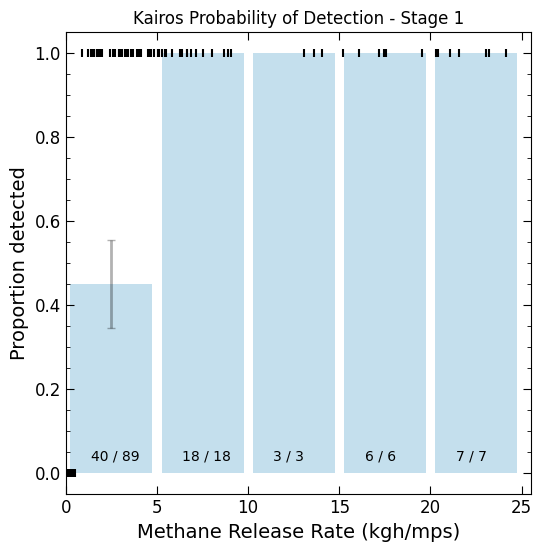

In [7]:
from methods_source import load_overpass_summary, load_operator_report_dictionary, abbreviate_op_name
from plot_methods import rand_jitter
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import pathlib


def plot_wind_normalized_MDL(operator, stage, n_bins, threshold, strict_discard=False, time_ave=60, gas_comp_source='km'):
    # Load overpass summary for operator, stage, and discard criteria:
    operator_df = load_overpass_summary(operator, stage, strict_discard, time_ave, gas_comp_source)

    # load Kairos' clean data report
    report_dictionary = load_operator_report_dictionary()
    operator_report = report_dictionary['kairos_1']

    operator_df['windspeed'] = operator_report['OperatorWindspeed']

    wind_normalized = []
    for index, row in operator_df.iterrows():
        if row['operator_quantification'] == 0:
            kgh_per_mps = 0
        else:
            kgh_per_mps = row['operator_quantification'] / row['windspeed']
        wind_normalized.append(kgh_per_mps)

    operator_df['operator_kgh_per_mps'] = wind_normalized

    # Apply QC filter
    # For SI: Carbon Mapper's QC for determining quantification only, and treat their detection column as applied to all points

    # if (operator == 'Carbon Mapper') or (operator == 'Scientific Aviation'):
    #     operator_df = operator_df[(operator_df.stanford_kept == 1)]
    if (operator == 'Scientific Aviation'):
        # Scientific Aviation explicitly stated that all data could be used in determining detection, their QC only
        # applied to quantification
        operator_df = operator_df[(operator_df.stanford_kept == 1)]
    else:
        operator_df = operator_df[(operator_df.qc_summary == 'pass_all')]

    # Must be non-zero values
    operator_df = operator_df.query('non_zero_release == True')

    # Select release under threshold value
    operator_df = operator_df.query('operator_kgh_per_mps <= @threshold')

    # Create bins for plot
    bins = np.linspace(0, threshold, n_bins + 1)
    detection_probability = np.zeros(n_bins)

    # These variables are for keeping track of values as I iterate through the bins in the for loop below:
    bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
    bin_median = np.zeros(n_bins)
    bin_two_sigma = np.zeros(n_bins)
    two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

    # For each bin, find number of data points and detection probability

    for i in range(n_bins):

        # Set boundary of bin
        bin_min = bins[i]
        bin_max = bins[i + 1]
        bin_median[i] = (bin_min + bin_max) / 2

        # Select data within the bin range
        binned_data = operator_df.loc[operator_df.operator_kgh_per_mps < bin_max].loc[
            operator_df.operator_kgh_per_mps >= bin_min]

        # Count the total number of overpasses detected within each bin
        bin_num_detected[i] = binned_data.operator_detected.sum()

        n = len(binned_data)
        bin_size[i] = n  # this is the y-value for the bin in the plot
        p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows
        detection_probability[i] = p

        # Standard Deviation of a binomial distribution
        sigma = np.sqrt(p * (1 - p) / n)
        bin_two_sigma[i] = 2 * sigma

        # Find the lower and upper bound defined by two sigma
        two_sigma_lower[i] = 2 * sigma
        two_sigma_upper[i] = 2 * sigma
        if 2 * sigma + p > 1:
            two_sigma_upper[i] = 1 - p  # probability cannot exceed 1
        if p - 2 * sigma < 0:
            two_sigma_lower[i] = p  # if error bar includes zero, set lower bound to p?

    detection_prob = pd.DataFrame({
        "bin_median": bin_median,
        "detection_prob_mean": detection_probability,
        "detection_prob_two_sigma_upper": two_sigma_upper,
        "detection_prob_two_sigma_lower": two_sigma_lower,
        "n_data_points": bin_size,
        "n_detected": bin_num_detected})

    # Function will output cm_detection and detection_prob

    detection_plot = detection_prob.copy()
    fig, ax = plt.subplots(1, figsize=(6, 6))

    # Set bin width:
    w = threshold / n_bins / 2.5

    # Use n_bins set above
    for i in range(n_bins):
        ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}',
                    [detection_plot.bin_median[i] - w / 1.8, 0.03], fontsize=10)

    # for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
    detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean'] = np.nan

    # To avoid RuntimeWarning: All-NaN axis encountered, set yerr to None if all values are np.nan in sigma values
    # (this is the case for Carbon Mapper)

    sigma_lower = detection_plot.detection_prob_two_sigma_lower
    sigma_upper = detection_plot.detection_prob_two_sigma_upper

    if sigma_lower.isnull().all() or sigma_upper.isnull().all():
        y_error = None
    else:
        y_error = [sigma_lower, sigma_upper]

    # Plot bars and detection points
    ax.bar(detection_plot.bin_median,
           detection_plot.detection_prob_mean,
           # yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
           yerr=y_error,
           error_kw=dict(lw=2, capsize=3, capthick=1, alpha=0.3),
           width=threshold / n_bins - 0.5, alpha=0.6, color='#9ecae1', ecolor='black', capsize=2)

    # yulia's color: edgecolor="black",facecolors='none'
    x_data = rand_jitter(operator_df.operator_kgh_per_mps)

    ax.scatter(x_data, np.multiply(operator_df.operator_detected, 1),
               facecolors='black',
               marker='|')

    # Add more room on top and bottom
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([0, threshold + 0.5])

    # Axes formatting and labels
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=11)
    ax.set_xlabel('Methane Release Rate (kgh/mps)', fontsize=14)
    ax.set_ylabel('Proportion detected', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=12)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    plt.title(f'{operator} Probability of Detection - Stage {stage}')

    # Save figure

    if strict_discard == True:
        discard = 'strict'
    else:
        discard = 'lax'

    now = datetime.datetime.now()
    save_time = now.strftime("%Y%m%d")
    op_ab = abbreviate_op_name(operator)
    fig_name = f'detect_limit_{op_ab}_stage{stage}_{discard}_{save_time}'
    fig_path = pathlib.PurePath('04_figures', '01_paper_figs', fig_name)
    plt.savefig(fig_path)
    plt.show()

    return operator_df, detection_prob


kairos_df, kairos_detection = plot_wind_normalized_MDL('Kairos', 1, 5, 25, strict_discard=False, time_ave=60, gas_comp_source='km')
# kairos_overpasses = load_overpass_summary(operator='Kairos', strict_discard=False, stage=1)
#
# # load Kairos' clean data report
# report_dictionary = load_operator_report_dictionary()
# operator_report = report_dictionary['kairos_1']
#
# kairos_overpasses['windspeed'] = operator_report['OperatorWindspeed']
# kairos_overpasses['operator_kgh_per_mps'] = kairos_overpasses['operator_quantification'] / kairos_overpasses['windspeed']